#### Просмотр фильмов на языке оригинала - популярный‌ и действенный метод прокачаться при изучении иностранных языков. Важно выбрать фильм, который‌ подойдет по уровню сложности, чтобы студент понимал 50-70 % диалогов.<br>
#### `Цель:` разработать ML-решение для автоматического определения уровня сложности англоязычных фильмов.

Исходные данные: размеченный датасет с названиями фильмов, субтитрами и меткой уровня сложности языка (A1/A2/B1/B2/C1/C2). 

In [1]:
pip install -q spacy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q pysrt

Note: you may need to restart the kernel to use updated packages.


In [1]:
# импорт необходимых модулей
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import spacy
import pysrt
import os
import re
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import wordnet
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pulka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pulka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pulka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pulka\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Чтение данных из файлов.

#### Выборка с известными лэйблами

In [2]:
df = pd.read_excel('D:\мастерская NLP\English_level\movies_labels.xlsx')

In [3]:
df

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+
...,...,...,...
236,236,Matilda(2022),C1
237,237,Bullet train,B1
238,238,Thor: love and thunder,B2
239,239,Lightyear,B2


#### Выборка без лэйблов

In [4]:
def text_sub(path):
    films = os.listdir(path = path)
    data = {}
    for i in range(len(films)):
        subs = pysrt.open(path + films[i], encoding='iso-8859-1')
        subt=[]
        for sub in subs:
            subt.append(sub.text_without_tags.split('\n'))
        data[films[i]] = subt
    data = pd.DataFrame({'Movie': films, 'Subtitles': data.values()})
    return data

In [5]:
data_1 = text_sub('D:/мастерская NLP/English_level/Subtitles_all/Subtitles/')

In [6]:
data_1['Movie'] = [i[:-4] for i in data_1['Movie']]

In [7]:
data_1

,Movie,Subtitles
0,Dredd(2012),"[[America is an irradiated wasteIand.], [Withi..."
1,Despicable_Me(2010),"[[Excuse me, sir,, is there a commode?], [Just..."
2,The_secret_life_of_Walter_Mitty(2013),"[[Huh?], [Hi! Todd Mahar,, eHarmony.], [How ca..."
3,Shrek(2001),"[[anoXmous, https://thepiratebay.se/user/Zen_B..."
4,Deadpool(2016),"[[WordsKill, Edited by ahmedhamdy90 / subscene..."
...,...,...
110,Matilda(1996),"[[(MUSIC)], [ NARRATOR: Everyone is born,], [b..."
111,Her(2013),"[[Advertise your product or brand here, contac..."
112,The_Fundamentals_of_Caring(2016),"[[Caregiving is not just, about feeding and cl..."
113,The_Intern(2015),"[[Freud said, ""love and work., Work and love.]..."


In [105]:
data_2 = data_1.merge(df, on= 'Movie')

In [106]:
data_2 = data_2.drop('id',axis = 1)

In [107]:
data_2

,Movie,Subtitles,Level
0,Dredd(2012),"[[America is an irradiated wasteIand.], [Withi...",A2/A2+
1,Despicable_Me(2010),"[[Excuse me, sir,, is there a commode?], [Just...",B2
2,The_secret_life_of_Walter_Mitty(2013),"[[Huh?], [Hi! Todd Mahar,, eHarmony.], [How ca...",B1
3,Shrek(2001),"[[anoXmous, https://thepiratebay.se/user/Zen_B...",B1
4,Deadpool(2016),"[[WordsKill, Edited by ahmedhamdy90 / subscene...",B2
...,...,...,...
105,Matilda(1996),"[[(MUSIC)], [ NARRATOR: Everyone is born,], [b...",B1
106,Her(2013),"[[Advertise your product or brand here, contac...","A2/A2+, B1"
107,The_Fundamentals_of_Caring(2016),"[[Caregiving is not just, about feeding and cl...",B1
108,The_Intern(2015),"[[Freud said, ""love and work., Work and love.]...",B2


### A2

In [108]:
data_3 = text_sub('D:/мастерская NLP/English_level/Subtitles_all/A2/')

In [109]:
data_3['Level'] = 'A2'

In [110]:
data_3['Movie'] = [i[:-4] for i in data_3['Movie']]

In [111]:
data_3

,Movie,Subtitles,Level
0,The Walking Dead-S01E03-Tell It To The Frogs.E...,"[[( thunder rumbling )], [Merle:, That's right...",A2
1,The Walking Dead-S01E05-Wildfire.English,"[[- ( walkie-talkie squawks ), - Rick: Morgan,...",A2
2,The Walking Dead-S01E02-Guts.English,"[[- ( birds chirping ), - ( bugs chittering )]...",A2
3,The Walking Dead-S01E04-Vatos.English,"[[( birds chirping )], [- What?, - Nothing.], ...",A2
4,The Walking Dead-S01E06-TS-19.English,"[[- ( people yelling ), - ( radio chatter )], ...",A2
5,The Walking Dead-S01E01-Days Gone Bye.English,"[[( bugs chittering )], [( brakes squeak )], [...",A2


### B1

In [112]:
data_4 = text_sub('D:/мастерская NLP/English_level/Subtitles_all/B1/')

In [113]:
data_4['Level'] = 'B1'

In [114]:
data_4['Movie'] = [i[:-4] for i in data_4['Movie']]

In [115]:
data_4.head()

,Movie,Subtitles,Level
0,Seven.Worlds.One.Planet.S01E06.2160p.BluRay.Re...,"[[One continent on our planet changes], [more ...",B1
1,Spirit.Stallion.of.the.Cimarron.EN,"[[''Spirit Stallion of the Cimarron''], [The s...",B1
2,AmericanBeauty1999.BRRip,"[[I need a father who's a role model,, not som...",B1
3,Seven.Worlds.One.Planet.S01E01.2160p.BluRay.Re...,"[[200 million years ago,], [our planet looked ...",B1
4,Seven.Worlds.One.Planet.S01E07.2160p.BluRay.Re...,"[[Africa.], [No continent on Earth today, has ...",B1


### B2

In [116]:
data_5 = text_sub('D:/мастерская NLP/English_level/Subtitles_all/B2/')

In [117]:
data_5['Level'] = 'B2'

In [118]:
data_5['Movie'] = [i[:-4] for i in data_5['Movie']]

In [119]:
data_5.head()

,Movie,Subtitles,Level
0,"Crown, The S01E01 - Wolferton Splash.en","[[In seeking his British, nationalization, His...",B2
1,Suits.Episode 1- Denial,"[[You're the most amazing woman, I have ever m...",B2
2,Crazy4TV.com - Suits.S06E06.720p.BluRay.x265.H...,"[[(HARVEY READING)], [I've been after Sutter, ...",B2
3,Suits.S02E08.HDTV.x264-EVOLVE,"[[[Car horn blares]], [You're late.], [Nope. 3...",B2
4,Virgin.River.S01E07.INTERNAL.720p.WEB.x264-STRiFE,"[[Are you sure I can't convince you to stay?],...",B2


### C1

In [120]:
data_6 = text_sub('D:/мастерская NLP/English_level/Subtitles_all/C1/')

In [121]:
data_6['Level'] = 'C1'

In [122]:
data_6['Movie'] = [i[:-4] for i in data_6['Movie']]

In [123]:
data_6.head()

,Movie,Subtitles,Level
0,Suits S04E11 EngSub,[],C1
1,Downton Abbey - S01E01 - Episode 1.eng.SDH,"[[[TELEGRAPH MACHINE BEEPING]], [[TRAIN WHISTL...",C1
2,Suits S04E08 EngSub,[],C1
3,Downton Abbey - S01E02 - Episode 2.eng.SDH,"[[Here we are, ma'am, Crawley House.], [For go...",C1
4,Downton Abbey - S01E03 - Episode 3.eng.SDH,"[[There you are, Mr. Bates., It's in. Came thi...",C1


### Объединение в один датафрейм

In [124]:
df = pd.concat([data_2, data_3, data_4, data_5, data_6]).reset_index(drop=True)

In [125]:
df

,Movie,Subtitles,Level
0,Dredd(2012),"[[America is an irradiated wasteIand.], [Withi...",A2/A2+
1,Despicable_Me(2010),"[[Excuse me, sir,, is there a commode?], [Just...",B2
2,The_secret_life_of_Walter_Mitty(2013),"[[Huh?], [Hi! Todd Mahar,, eHarmony.], [How ca...",B1
3,Shrek(2001),"[[anoXmous, https://thepiratebay.se/user/Zen_B...",B1
4,Deadpool(2016),"[[WordsKill, Edited by ahmedhamdy90 / subscene...",B2
...,...,...,...
268,Suits.S03E08.480p.HDTV.x264-mSD,"[[I get Ava Hessington acquitted,], [Darby bac...",C1
269,Suits S04E06 EngSub,[],C1
270,Suits.S03E07.HDTV.x264-mSD,"[[Previously on, Suits...], [It's going up, on...",C1
271,Suits S04E03 EngSub,[],C1


In [134]:
df.to_excel(r'C:\Users\pulka\OneDrive\Рабочий стол\nlp.xlsx')

In [126]:
df['Level']= df['Level'].replace('A2/A2+','A2+')
df['Level']= df['Level'].replace('A2/A2+, B1','B1')
df['Level']= df['Level'].replace('B1, B2','B2')

In [127]:
df['Level'].unique()

array(['A2+', 'B2', 'B1', 'C1', 'A2'], dtype=object)

### Предобработка данных.

Определение признаков.

In [128]:
X,y = df['Subtitles'], df['Level']

In [129]:
nlp = spacy.load("en_core_web_sm")

In [130]:
# функция для обработки текста.
def preprocess(text):
    # удаление символов
    document = re.sub(r'\W', ' ', str(text))
    # удаление одиноко стоящих слов
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # приведение к нижнему регистру 
    document = document.lower()
    # токенизация
    #document = nltk.word_tokenize(document,language = "english")
    # лемматизация
    spacy_results = nlp(document)
    document = ' '.join([token.lemma_ for token in spacy_results])
    return document

In [131]:
X = X.apply(preprocess)

In [132]:
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(X).toarray()

### Проверка баланса классов в выборке.

<AxesSubplot: >

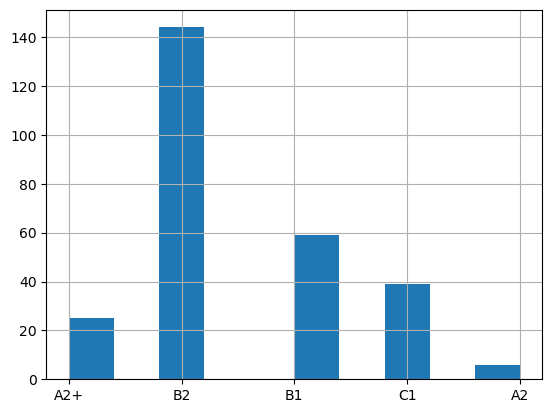

In [133]:
y.hist()

#### Борьба с диссбалансом.

In [135]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

<AxesSubplot: >

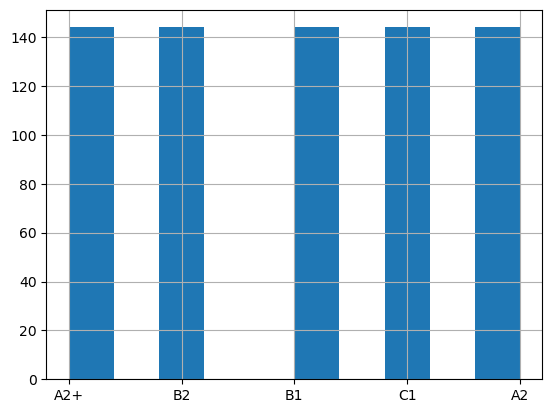

In [136]:
y_resampled.hist()

Делим нашу выборку на тренировочную и тестовую.

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size = 0.3, random_state = 42)

In [140]:
# проверка размерности
print(f'All:{X_resampled.shape}')
print(f'train:{X_train.shape}')
print(f'test:{X_test.shape}')

All:(720, 29854)
train:(504, 29854)
test:(216, 29854)


#### Модель `CatBoostClassifier `

In [141]:
train_pool = Pool(X_train, 
                  y_train)

test_pool = Pool(X_test, 
                 y_test) 

model = CatBoostClassifier(verbose=False)
#train the model
model.fit(train_pool) 


### Возьмем в качестве метрики `accuracy`

In [142]:
predict_train = model.predict(X_train)
print(accuracy_score(y_train, predict_train))

1.0


In [143]:
predict_test = model.predict(X_test)
print(accuracy_score(y_test, predict_test))

0.9166666666666666


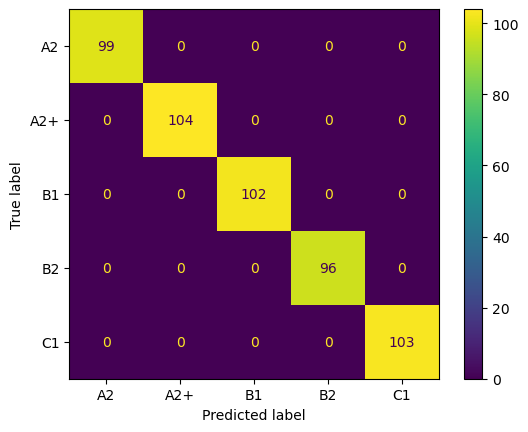

In [144]:
cm = confusion_matrix(y_train, predict_train, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
display_labels = model.classes_)
disp.plot()
plt.show()


Для анализа текстов субтитров и определения по ним уровня знания английского языка была разработана модель машинного обучения.<br>
Модель - `CatBoostClassifier`, в качестве метрики выбрано количество правильных ответов `accuracy`, ее значение на тестовой выборке составило `0.91`.